**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 코랩에서 실행되는 노트북인가?
IS_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


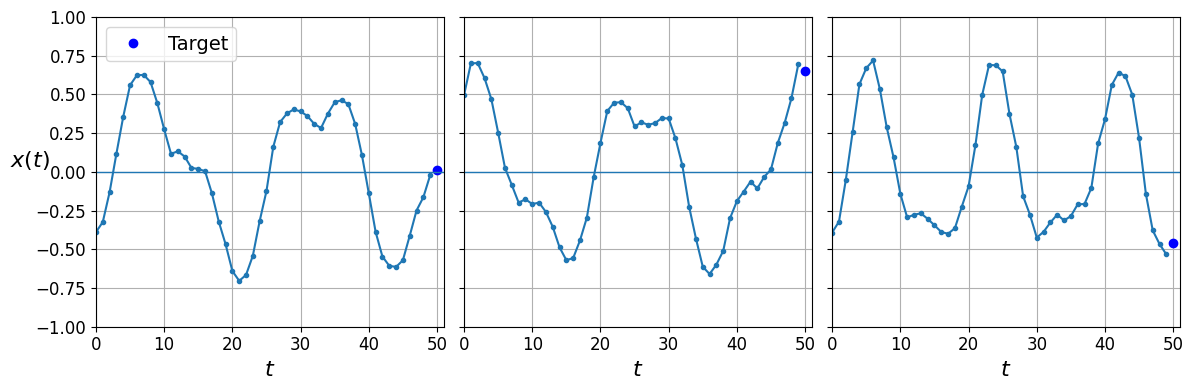

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020514928

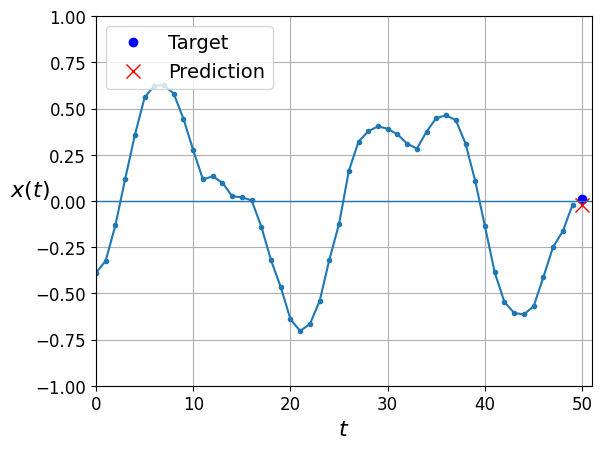

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(1)])
model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

219/219 [==============================] - 2s 3ms/step - loss: 0.0657 - val_loss: 0.0280


In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0280


0.028020434081554413

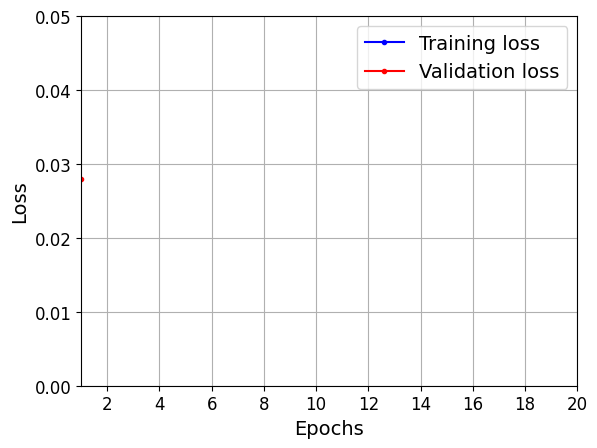

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 936us/step


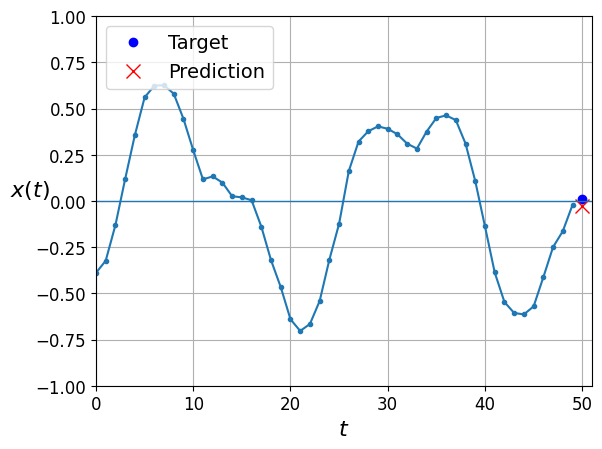

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [12]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

219/219 [==============================] - 12s 53ms/step - loss: 0.1274 - val_loss: 0.0331


In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0331


0.03305063396692276

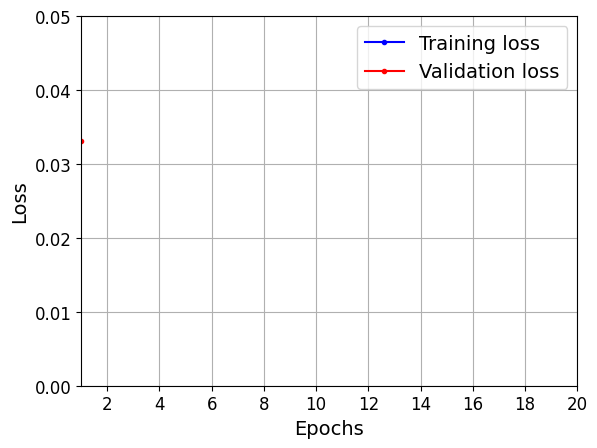

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 10ms/step


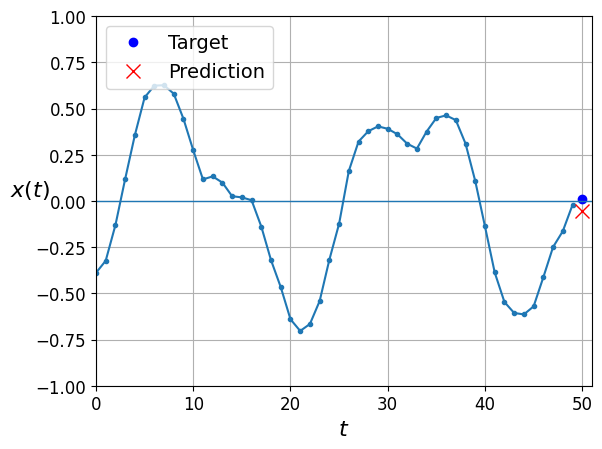

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

In [16]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1)
    ]
)
model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

219/219 [==============================] - 48s 211ms/step - loss: 0.0302 - val_loss: 0.0071


In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 28ms/step - loss: 0.0071


0.007062870543450117

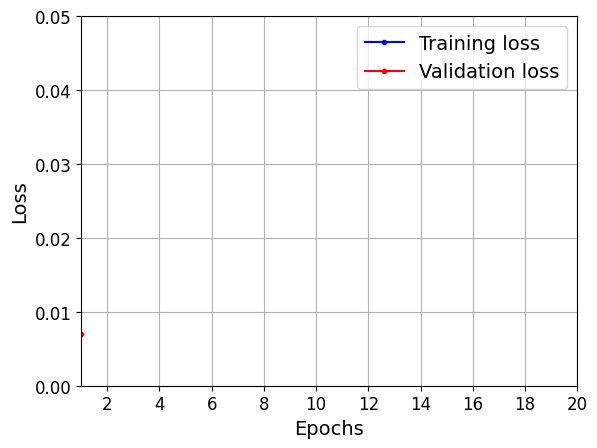

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 2s 29ms/step


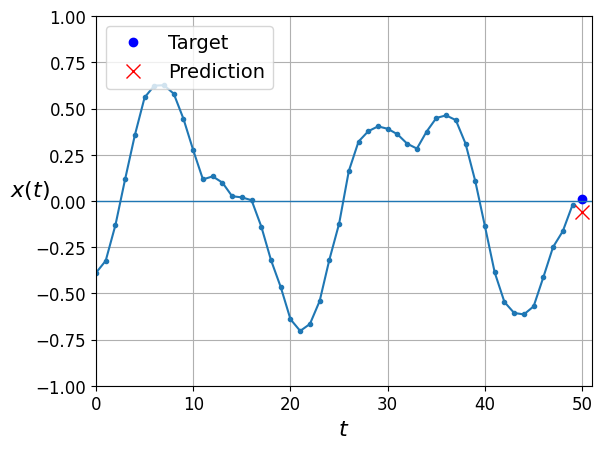

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환한다:

In [20]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1)
    ]
)
model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

219/219 [==============================] - 28s 122ms/step - loss: 0.0151 - val_loss: 0.0044


In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 20ms/step - loss: 0.0044


0.004420146811753511

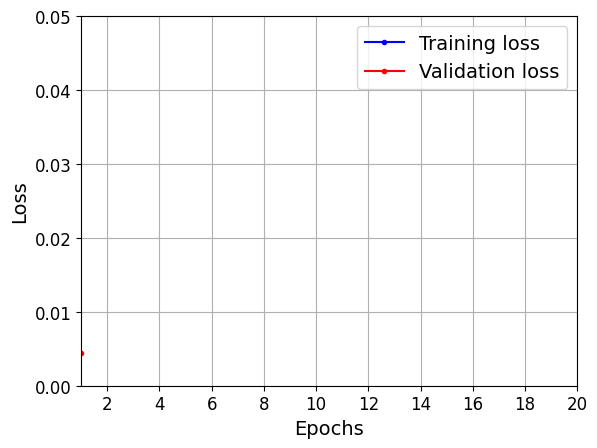

In [22]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 20ms/step


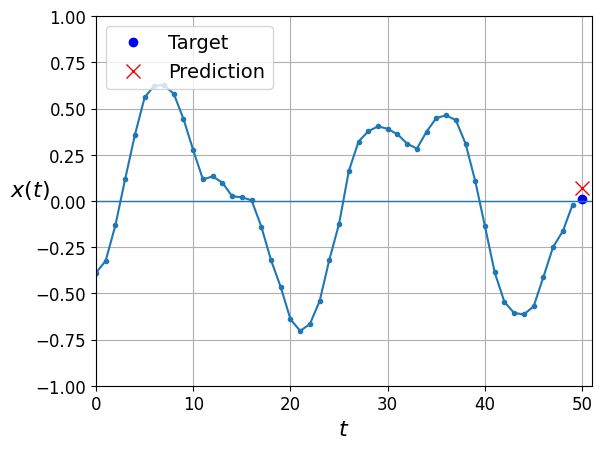

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

In [24]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 34ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


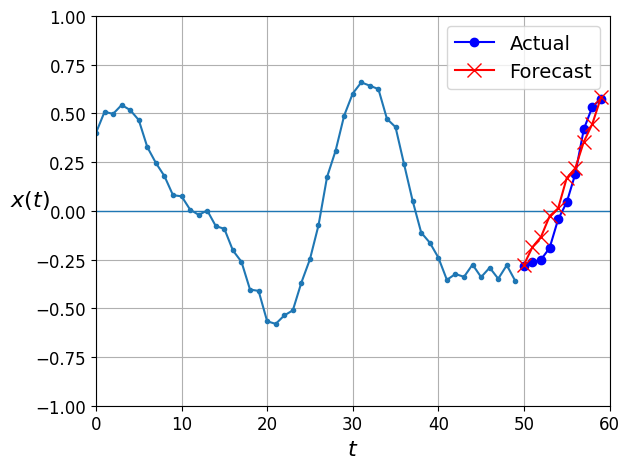

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bo-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'rx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig('forecast_ahead_plot')
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 본다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 한다.

In [27]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, n_steps:, 0]

이제 하나씩 다음 10개의 값을 예측한다:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 22ms/step


In [29]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.0320635

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 본다:

In [30]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)  # 마지막 타임 스텝 값을 선택해 10번 반복한다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25845674

In [31]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(10)])
model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 1s 3ms/step - loss: 0.1607 - val_loss: 0.0771


이제 동시에 다음 10개의 값을 모두 예측하는 RNN을 만들어 본다:

In [32]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(10)
    ]
)
model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 30s 130ms/step - loss: 0.0730 - val_loss: 0.0310


In [33]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 211ms/step


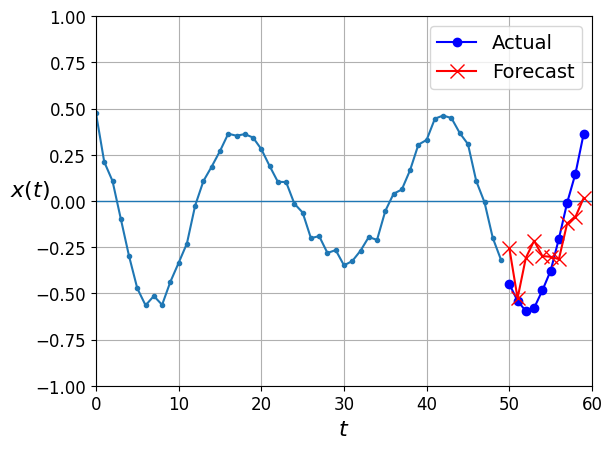

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 본다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측한다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측한다. 이 모델은 인과 모델이다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있다.

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [36]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [37]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 26s 111ms/step - loss: 0.0497 - last_time_step_mse: 0.0388 - val_loss: 0.0402 - val_last_time_step_mse: 0.0288


In [38]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 215ms/step


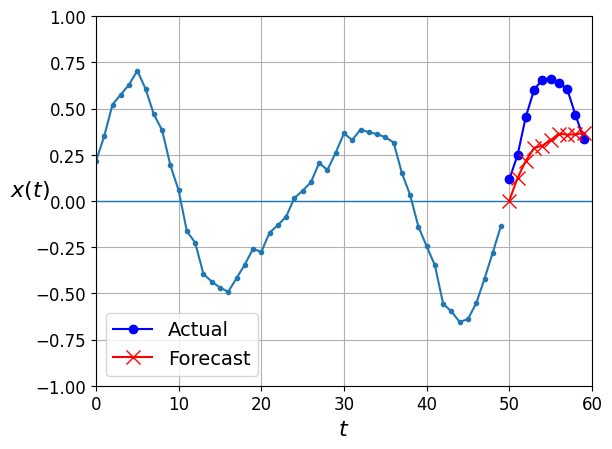

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 배치 정규화를 사용한 심층 RNN

In [40]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 27s 118ms/step - loss: 0.1337 - last_time_step_mse: 0.1197 - val_loss: 0.0767 - val_last_time_step_mse: 0.0671


# 층 정규화를 사용한 심층 RNN

In [41]:
from tensorflow.keras.layers import LayerNormalization

In [42]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
model = keras.models.Sequential(
    [
        keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
        keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 59s 241ms/step - loss: 0.1097 - last_time_step_mse: 0.1018 - val_loss: 0.0633 - val_last_time_step_mse: 0.0568


# 사용자 정의 RNN 클래스 만들기

In [44]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, 'get_initial_state', self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [45]:
model = keras.models.Sequential(
    [
        MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
        MyRNN(LNSimpleRNNCell(20), return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 59s 260ms/step - loss: 0.1236 - last_time_step_mse: 0.1130 - val_loss: 0.0621 - val_last_time_step_mse: 0.0498


In [46]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 11s 18ms/step - loss: 0.0798 - last_time_step_mse: 0.0659 - val_loss: 0.0576 - val_last_time_step_mse: 0.0457


In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0576 - last_time_step_mse: 0.0457


[0.057612862437963486, 0.04574558883905411]

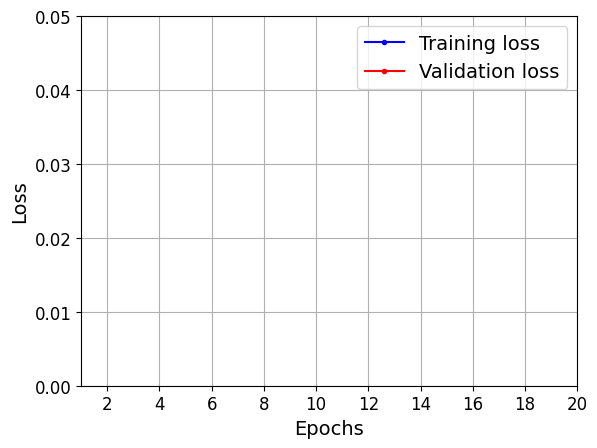

In [48]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [49]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 565ms/step


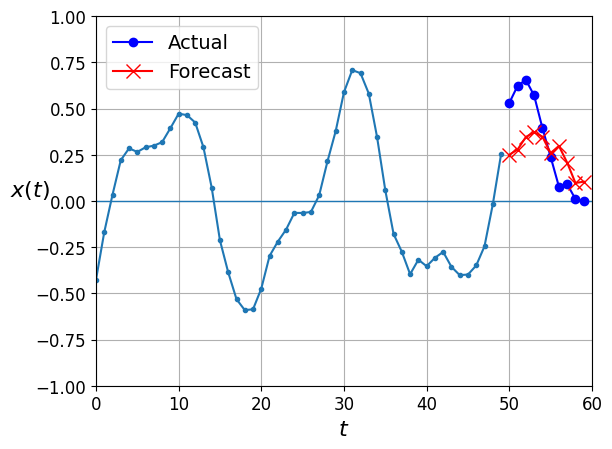

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [51]:
model = keras.models.Sequential(
    [
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 6s 17ms/step - loss: 0.0727 - last_time_step_mse: 0.0645 - val_loss: 0.0520 - val_last_time_step_mse: 0.0422


In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0520 - last_time_step_mse: 0.0422


[0.05197123438119888, 0.0422242097556591]

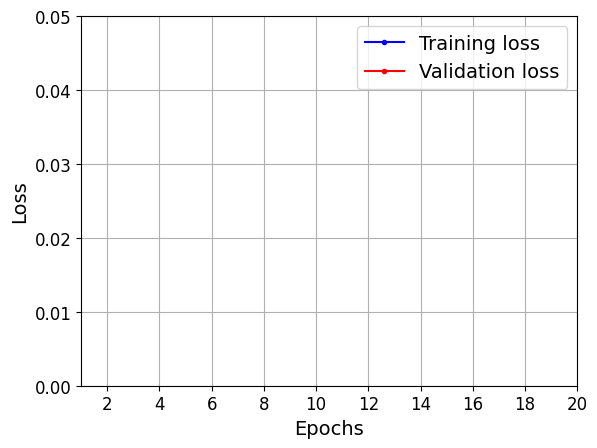

In [53]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [54]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 502ms/step


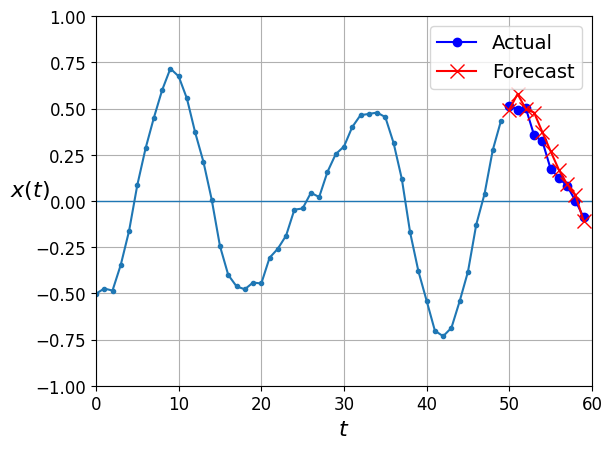

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [56]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))
history = model.fit(X_train, Y_train[:, 3::2], epochs=1, validation_data=(X_valid, Y_valid[:, 3::2]))

219/219 [==============================] - 8s 14ms/step - loss: 0.0711 - last_time_step_mse: 0.0645 - val_loss: 0.0465 - val_last_time_step_mse: 0.0400


## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0653 - last_time_step_mse: 0.0536 - val_loss: 0.0384 - val_last_time_step_mse: 0.0261
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0341 - last_time_step_mse: 0.0209 - val_loss: 0.0309 - val_last_time_step_mse: 0.0185
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0297 - last_time_step_mse: 0.0172 - val_loss: 0.0279 - val_last_time_step_mse: 0.0155
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0275 - last_time_step_mse: 0.0154 - val_loss: 0.0264 - val_last_time_step_mse: 0.0145
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0262 - last_time_step_mse: 0.0142 - val_loss: 0.0261 - val_last_time_step_mse: 0.0143
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0253 - last_time_step_mse: 0.0135 - val_loss: 0.0245 - val_last_time_step_mse: 0.0123
Epoch 7/20
219/219 [==

다음은 논문에 정의된 원본 WaveNet이다. ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용한다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩한다:

In [63]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [64]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding='causal', dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [65]:
n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper
inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding='causal')(inputs)
skip_to_last = []
for dilation_rate in [2 ** i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation='relu')(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation='softmax')(z)
model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [66]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 4s 14ms/step - loss: 0.1296 - last_time_step_mse: 0.1257 - val_loss: 0.1224 - val_last_time_step_mse: 0.1205
Epoch 2/2
219/219 [==============================] - 3s 12ms/step - loss: 0.1224 - last_time_step_mse: 0.1182 - val_loss: 0.1212 - val_last_time_step_mse: 0.1191


이 장에서 RNN의 기초 사항을 살펴보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아보았다. 다음에는 RNN을 자연어 처리에 적용해 보겠다. 그리고 RNN에 대해 더 자세히 배워 보겠다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴보겠다.

# 연습